# 1er Parcial _ Inteligencia Artificial

##Estudiante: Coa Veliz Diego Armando

##Dataset : PCA NN and CNN with Keras

15000 EJEMPLOS

4098 COLUMNAS (4096 informacion de pixeles), 2 columnas de "label" y "character"
##URL : https://www.kaggle.com/code/omarlarasa/pca-nn-and-cnn-with-keras/input





In [107]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

# Libreria para graficos
from matplotlib import pyplot

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

import pandas as pd

In [108]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
# Cargar datos desde el archivo CSV
data = pd.read_csv('/content/drive/Othercomputers/Mi PC/Semestre 2-2024/SIS420 - INTELIGENCIA ARTIFICIAL I/1erParcial_IA/1erParcial_datasets/20.PCA NN and CNN with Keras/chineseMNIST.csv')

# Verificar las primeras filas del dataframe para entender su estructura
print(data.head())


   pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   pixel_8  pixel_9  ...  pixel_4088  pixel_4089  pixel_4090  pixel_4091  \
0        0        0  ...           0           0           0           0   
1        0        0  ...           0           0           0           0   
2        0        0  ...           0           0           0           0   
3        0        0  ...           0           0           0           0   
4        0        0  ...           0           0           0           0   

   pixel_4092  pixel_4093  pixel_4094  pixel_4095  label  character  
0         

In [110]:
print(data.shape)  # Muestra el número de filas y columnas

(15000, 4098)


# 1.      Inserte atributos que contengan:

- caracteres(pronunciacion),

- texto(Tipo_numero),

- valores booleanos("simetria")

relacionados a la temática del dataset elegido.

In [111]:
# Calcular brillo como el promedio de los valores de los píxeles
data['Brillo'] = data.iloc[:, :4096].mean(axis=1)
#Se calcula el promedio de los valores de los píxeles para cada fila (desde la columna 0 hasta la columna 4095).

# Calcular iluminación como el rango de los valores de los píxeles
data['Iluminacion'] = data.iloc[:, :4096].max(axis=1) - data.iloc[:, :4096].min(axis=1)
#Se calcula el rango de los valores de los píxeles para cada fila, que es la diferencia entre el valor máximo y el valor mínimo.

# Mostrar las nuevas columnas
print(data[['Brillo', 'Iluminacion']].head())

     Brillo  Iluminacion
0  3.866943          206
1  2.322510          191
2  4.155029          227
3  3.394287          205
4  3.656006          213


In [112]:
caracteres_unicos = data['character'].unique() # Obtener todos los caracteres únicos de la columna 'character'

lista_caracteres = caracteres_unicos.tolist() # Convertir el resultado a una lista

# Mostrar la lista
print(lista_caracteres)


['九', '十', '百', '千', '万', '亿', '零', '一', '二', '三', '四', '五', '六', '七', '八']


In [113]:
label_unicos = data['label'].unique() # Obtener todos los label únicos de la columna 'label'

lista_label = label_unicos.tolist() # Convertir el resultado a una lista

# Mostrar la lista
print(lista_label)


[9, 10, 100, 1000, 10000, 100000000, 0, 1, 2, 3, 4, 5, 6, 7, 8]


Se separaran los caracteres simétricos de los no simétricos, se utilizara una lista de caracteres simétricos y luego se analizara el dataset.

In [114]:
# Lista de caracteres simétricos
simetricos = ['一', '二', '三', '十', '百', '八']  # Ajusta según tus caracteres simétricos

# Añadir la columna "Simetria" como booleano (1/0) sin reemplazar 'data'
data['Simetria'] = data['character'].apply(lambda x: 1 if x in simetricos else 0)

# Mostrar el DataFrame con la nueva columna
print(data.iloc[:, -7:])

       pixel_4094  pixel_4095  label character    Brillo  Iluminacion  \
0               0           0      9         九  3.866943          206   
1               0           0      9         九  2.322510          191   
2               0           0      9         九  4.155029          227   
3               0           0      9         九  3.394287          205   
4               0           0      9         九  3.656006          213   
...           ...         ...    ...       ...       ...          ...   
14995           0           0      8         八  2.160645          163   
14996           0           0      8         八  1.898926          170   
14997           0           0      8         八  1.854980          154   
14998           0           0      8         八  1.808350          169   
14999           0           0      8         八  1.995850          146   

       Simetria  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...

In [115]:
#Filas específicas (fila n a la n)
print(data[['character', 'Simetria']].iloc[10100:10120])

      character  Simetria
10100         四         0
10101         四         0
10102         四         0
10103         四         0
10104         四         0
10105         四         0
10106         四         0
10107         四         0
10108         四         0
10109         四         0
10110         四         0
10111         四         0
10112         四         0
10113         四         0
10114         四         0
10115         四         0
10116         四         0
10117         四         0
10118         四         0
10119         四         0


In [116]:
# Clasificación de "label" como "básico" o "complejo" basado en la columna 'label'
def clasificar_tipo_numero(label):
    if label < 10:  # Números básicos [9,8,7,6,5,4,3,2,1,0]
        return 'Basico'
    else:  # Números complejos [10, 100, 1000, 10000, 100000000]
        return 'Complejo'

# Añadir la columna "Tipo_numero" usando la columna 'label'
data['Tipo_numero'] = data['label'].apply(clasificar_tipo_numero)

# Mostrar el DataFrame con la nueva columna
print(data[['character', 'label', 'Tipo_numero','Simetria']])
print(data[['character', 'label', 'Tipo_numero','Simetria']].iloc[5000:5010])

      character  label Tipo_numero  Simetria
0             九      9      Basico         0
1             九      9      Basico         0
2             九      9      Basico         0
3             九      9      Basico         0
4             九      9      Basico         0
...         ...    ...         ...       ...
14995         八      8      Basico         1
14996         八      8      Basico         1
14997         八      8      Basico         1
14998         八      8      Basico         1
14999         八      8      Basico         1

[15000 rows x 4 columns]
     character      label Tipo_numero  Simetria
5000         亿  100000000    Complejo         0
5001         亿  100000000    Complejo         0
5002         亿  100000000    Complejo         0
5003         亿  100000000    Complejo         0
5004         亿  100000000    Complejo         0
5005         亿  100000000    Complejo         0
5006         亿  100000000    Complejo         0
5007         亿  100000000    Complejo         0
50

In [117]:
# Mapa de pronunciaciones
pronunciacion = {
    '零': 'líng',  # 0
    '一': 'yī',    # 1
    '二': 'èr',    # 2
    '三': 'sān',   # 3
    '四': 'sì',    # 4
    '五': 'wǔ',    # 5
    '六': 'liù',   # 6
    '七': 'qī',    # 7
    '八': 'bā',    # 8
    '九': 'jiǔ',   # 9
    '十': 'shí',   # 10
    '百': 'bǎi',   # 100
    '千': 'qiān',  # 1000
    '万': 'wàn',   # 10,000
    '亿': 'yì'     # 100,000,000
}

# Crear una nueva columna de pronunciación
data['pronunciacion'] = data['character'].map(pronunciacion)

# Mostrar el DataFrame con la nueva columna
print(data[['character', 'label', 'Tipo_numero','Simetria', "pronunciacion"]])


      character  label Tipo_numero  Simetria pronunciacion
0             九      9      Basico         0           jiǔ
1             九      9      Basico         0           jiǔ
2             九      9      Basico         0           jiǔ
3             九      9      Basico         0           jiǔ
4             九      9      Basico         0           jiǔ
...         ...    ...         ...       ...           ...
14995         八      8      Basico         1            bā
14996         八      8      Basico         1            bā
14997         八      8      Basico         1            bā
14998         八      8      Basico         1            bā
14999         八      8      Basico         1            bā

[15000 rows x 5 columns]


In [118]:
print(data.iloc[:, -7:])

       label character    Brillo  Iluminacion  Simetria Tipo_numero  \
0          9         九  3.866943          206         0      Basico   
1          9         九  2.322510          191         0      Basico   
2          9         九  4.155029          227         0      Basico   
3          9         九  3.394287          205         0      Basico   
4          9         九  3.656006          213         0      Basico   
...      ...       ...       ...          ...       ...         ...   
14995      8         八  2.160645          163         1      Basico   
14996      8         八  1.898926          170         1      Basico   
14997      8         八  1.854980          154         1      Basico   
14998      8         八  1.808350          169         1      Basico   
14999      8         八  1.995850          146         1      Basico   

      pronunciacion  
0               jiǔ  
1               jiǔ  
2               jiǔ  
3               jiǔ  
4               jiǔ  
...            

# 2. Duplique los ejemplos del dataset considerando rangos y criterios que garanticen la consistencia del dataset.

In [119]:
# Duplicar 15000 ejemplos de forma aleatoria
num_duplicados = 15000
indices_duplicados = np.random.choice(data.index, size=num_duplicados, replace=True)

# Crear un nuevo DataFrame con los duplicados y resetear el índice
duplicados = data.loc[indices_duplicados].reset_index(drop=True)

# Guardar los datos duplicados en una variable aparte
datos_duplicados = duplicados.copy()

# Modificaciones en los duplicados: ejemplo de cómo modificar la columna 'label'
# Restar 1 a los que son menores o igual a 10 en la columna 'label'
duplicados.loc[(duplicados['label'] < 10) & (duplicados['label'] > 0), 'label'] -= 1

# Asegurarse de que 'label' es de tipo string para agregar '0'
duplicados['label'] = duplicados['label'].astype(str)

# Agregar un 0 a las filas con label igual a '1', '10' y '100'
duplicados.loc[duplicados['label'].isin(['1', '10', '100']), 'label'] += '0'

# Intercambiar cantidades de 0 entre 10000 y 100000000
duplicados.loc[duplicados['label'] == '10000', 'label'] = '100000000'
duplicados.loc[duplicados['label'] == '100000000', 'label'] = '10000'

# Convertir la columna 'label' de vuelta a int
duplicados['label'] = duplicados['label'].astype(int)

# --- Mantener coherencia en la columna 'character' en los duplicados ---

# Mapa entre label y character
label_to_character = {
    0: '零', 1: '一', 2: '二', 3: '三', 4: '四',
    5: '五', 6: '六', 7: '七', 8: '八', 9: '九',
    10: '十', 100: '百', 1000: '千', 10000: '万', 100000000: '亿'
}

# Recalcular la columna 'character' en base al valor de 'label'
duplicados['character'] = duplicados['label'].map(label_to_character)

# --- Mantener coherencia en las demás columnas ---

# Recalcular la columna "Simetria" en función de la columna 'character'
simetricos = ['一', '二', '三', '十', '百', '八']  # Ajusta según tus caracteres simétricos
duplicados['Simetria'] = duplicados['character'].apply(lambda x: 1 if x in simetricos else 0)

# Recalcular la columna "Tipo_numero" en función de la columna 'label'
def clasificar_tipo_numero(label):
    if label < 10:  # Números básicos [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
        return 'Basico'
    else:  # Números complejos [10, 100, 1000, 10000, 100000000]
        return 'Complejo'
duplicados['Tipo_numero'] = duplicados['label'].apply(clasificar_tipo_numero)

# Recalcular la columna "pronunciacion" en función de la columna 'character'
pronunciacion = {
    '零': 'líng', '一': 'yī', '二': 'èr', '三': 'sān', '四': 'sì',
    '五': 'wǔ', '六': 'liù', '七': 'qī', '八': 'bā', '九': 'jiǔ',
    '十': 'shí', '百': 'bǎi', '千': 'qiān', '万': 'wàn', '亿': 'yì'
}
duplicados['pronunciacion'] = duplicados['character'].map(pronunciacion)

# Concatenar los originales con los duplicados para obtener el DataFrame ampliado
data_ampliado = pd.concat([data, duplicados], ignore_index=True)

# Mostrar los datos duplicados con las columnas coherentes
print(duplicados[['character', 'label', 'Tipo_numero', 'Simetria', 'pronunciacion']])



      character  label Tipo_numero  Simetria pronunciacion
0             千   1000    Complejo         0          qiān
1             六      6      Basico         0           liù
2             八      8      Basico         1            bā
3             二      2      Basico         1            èr
4             万  10000    Complejo         0           wàn
...         ...    ...         ...       ...           ...
14995         六      6      Basico         0           liù
14996         十     10    Complejo         1           shí
14997         十     10    Complejo         1           shí
14998         万  10000    Complejo         0           wàn
14999         万  10000    Complejo         0           wàn

[15000 rows x 5 columns]


In [28]:
print(data_ampliado.iloc[:, -7:])

       label character    Brillo  Iluminacion  Simetria Tipo_numero  \
0          9         九  3.866943          206         0      Basico   
1          9         九  2.322510          191         0      Basico   
2          9         九  4.155029          227         0      Basico   
3          9         九  3.394287          205         0      Basico   
4          9         九  3.656006          213         0      Basico   
...      ...       ...       ...          ...       ...         ...   
29995      7         七  2.294189          199         0      Basico   
29996    100         百  1.373291          194         1    Complejo   
29997      2         二  1.603516          180         1      Basico   
29998   1000         千  3.308350          219         0    Complejo   
29999      7         七  1.773438          233         0      Basico   

      pronunciacion  
0               jiǔ  
1               jiǔ  
2               jiǔ  
3               jiǔ  
4               jiǔ  
...            

In [29]:
print(data_ampliado.iloc[:, -7:].iloc[15000:15020])

       label character    Brillo  Iluminacion  Simetria Tipo_numero  \
15000      4         四  2.683350          205         0      Basico   
15001   1000         千  1.047119          219         0    Complejo   
15002  10000         万  4.128906          177         0    Complejo   
15003  10000         万  2.723877          185         0    Complejo   
15004      3         三  1.895508          177         1      Basico   
15005      0         零  0.690430          146         0      Basico   
15006      7         七  2.764893          194         0      Basico   
15007      0         零  5.980957          197         0      Basico   
15008    100         百  2.820068          207         1    Complejo   
15009     10         十  0.899170          166         1    Complejo   
15010      2         二  1.236328          126         1      Basico   
15011  10000         万  1.643799          179         0    Complejo   
15012      8         八  2.422852          249         1      Basico   
15013 

Convertimos todas las columnas a valores numericos

In [30]:
# Verificar los valores únicos en 'Tipo_numero'
print(data_ampliado['Tipo_numero'].unique())

['Basico' 'Complejo']


In [31]:
# Convertir 'Tipo_numero' a valores numéricos (1 para 'B', 0 para 'C')
data_ampliado['Tipo_numero'] = data_ampliado['Tipo_numero'].map({'Basico': 1, 'Complejo': 0})

# Convertir la pronunciación a su longitud (cantidad de letras)
data_ampliado['pronunciacion'] = data_ampliado['pronunciacion'].map(lambda x: len(x) if isinstance(x, str) else x)

# Convertir la columna 'character' a su valor numérico correspondiente
data_ampliado['character'] = data_ampliado['character'].map({
    '零': 0, '一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6,
    '七': 7, '八': 8, '九': 9, '十': 10, '百': 100, '千': 1000,
    '万': 10000, '亿': 100000000
})

# Comprobar el que las columnas 'Tipo_numero', 'pronunciacion', 'character' sean valores numericos
print(data_ampliado[['Tipo_numero', 'pronunciacion', 'character']].head())


   Tipo_numero  pronunciacion  character
0            1              3          9
1            1              3          9
2            1              3          9
3            1              3          9
4            1              3          9


In [32]:
print(data_ampliado.iloc[:, -7:])

       label  character    Brillo  Iluminacion  Simetria  Tipo_numero  \
0          9          9  3.866943          206         0            1   
1          9          9  2.322510          191         0            1   
2          9          9  4.155029          227         0            1   
3          9          9  3.394287          205         0            1   
4          9          9  3.656006          213         0            1   
...      ...        ...       ...          ...       ...          ...   
29995      7          7  2.294189          199         0            1   
29996    100        100  1.373291          194         1            0   
29997      2          2  1.603516          180         1            1   
29998   1000       1000  3.308350          219         0            0   
29999      7          7  1.773438          233         0            1   

       pronunciacion  
0                  3  
1                  3  
2                  3  
3                  3  
4       

In [33]:
#p_unicos = data_ampliado['pronunciacion'].unique() # Obtener todos los caracteres únicos de la columna 'pronunciacion'

#lista_pronunciacion = p_unicos.tolist() # Convertir el resultado a una lista

# Mostrar la lista
#print(lista_pronunciacion)

# 3.      Crear una grafica representativa de los datos del dataset inicial y otra con los datos del dataset sintético generado.

Dataset Original

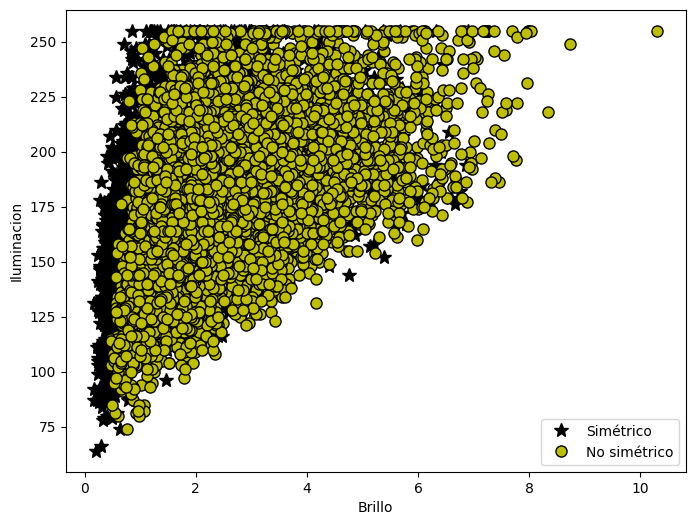

In [34]:
# Asignamos los valores de Brillo e Iluminacion a X
X = data[['Brillo', 'Iluminacion']].values #Extrae las columnas 'Brillo' e 'Iluminacion' del data y las convierte en un arreglo de NumPy (con .values).

# Asignamos la columna 'Simetria' como "y"
y = data['Simetria'].values

def plotData(X, y):
    # Crea una nueva figura
    fig = pyplot.figure(figsize=(8, 6))

    # Encuentra los índices de los ejemplos positivos y negativos
    pos = y == 1
    neg = y == 0

    # Grafica los ejemplos
    pyplot.plot(X[pos, 0], X[pos, 1], 'k*', lw=2, ms=10, label='Simétrico')
    pyplot.plot(X[neg, 0], X[neg, 1], 'ko', mfc='y', ms=8, mec='k', mew=1, label='No simétrico')

    # Adiciona etiquetas a los ejes
    pyplot.xlabel('Brillo')
    pyplot.ylabel('Iluminacion')
    pyplot.legend()

# Llamada a la función para graficar los datos
plotData(X, y)

# Mostrar el gráfico
pyplot.show()


In [35]:
print(data.shape)

(15000, 4103)


Dataset SINTETICO

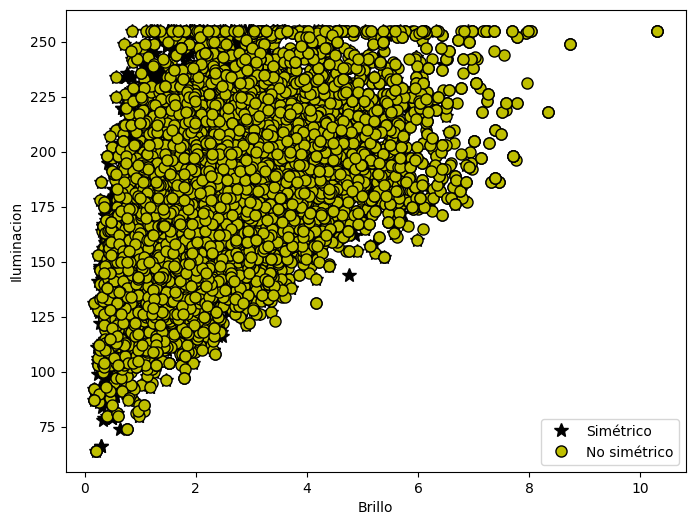

In [36]:
# Asignamos los valores de Brillo e Iluminacion a X
X = data_ampliado[['Brillo', 'Iluminacion']].values

# Asignamos la columna 'Simetria' como "y"
y = data_ampliado['Simetria'].values

def plotData(X, y):
    # Crea una nueva figura
    fig = pyplot.figure(figsize=(8, 6)) #Superficie donde se dibujarán los datos.

    # Encuentra los índices de los ejemplos positivos y negativos
    pos = y == 1
    neg = y == 0

    # Grafica los ejemplos
    pyplot.plot(X[pos, 0], X[pos, 1], 'k*', lw=2, ms=10, label='Simétrico')
    pyplot.plot(X[neg, 0], X[neg, 1], 'ko', mfc='y', ms=8, mec='k', mew=1, label='No simétrico')

    # Adiciona etiquetas a los ejes
    pyplot.xlabel('Brillo')
    pyplot.ylabel('Iluminacion')
    pyplot.legend()

# Llamada a la función para graficar los datos
plotData(X, y)

# Mostrar el gráfico
pyplot.show()


In [37]:
print(data_ampliado.shape)

(30000, 4103)


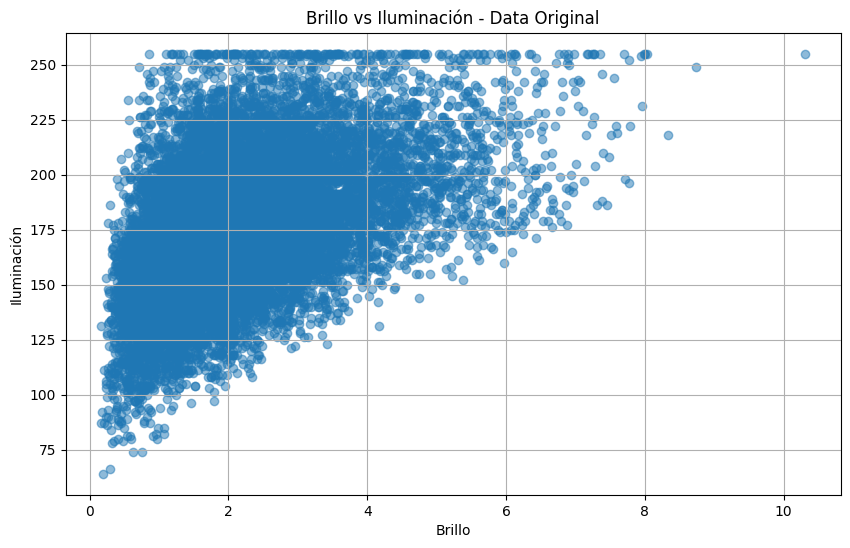

(15000, 4103)


In [38]:
# Graficar el Dataset original
pyplot.figure(figsize=(10, 6))
pyplot.scatter(data['Brillo'], data['Iluminacion'], alpha=0.5)
pyplot.title('Brillo vs Iluminación - Data Original')
pyplot.xlabel('Brillo')
pyplot.ylabel('Iluminación')
pyplot.grid()
pyplot.show()
print(data.shape)


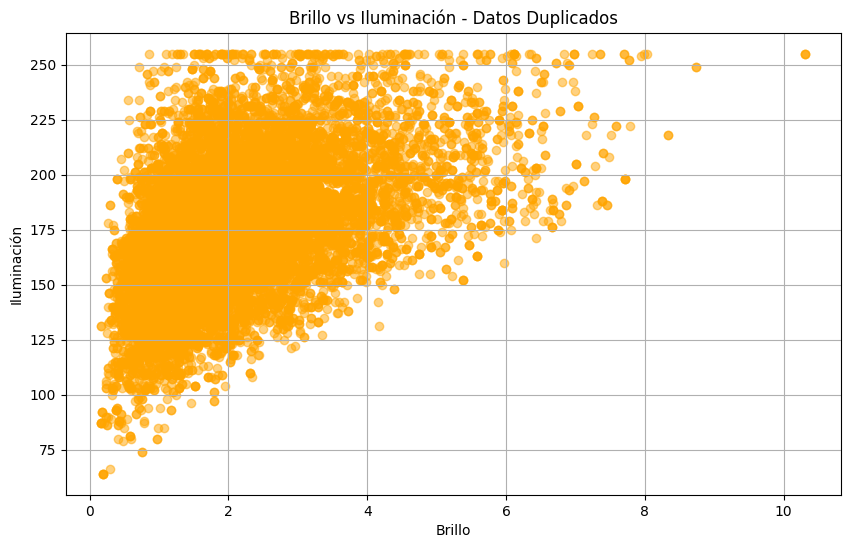

(15000, 4103)


In [39]:
# Graficar el dataset de duplicados
pyplot.figure(figsize=(10, 6))
pyplot.scatter(datos_duplicados['Brillo'], datos_duplicados['Iluminacion'], alpha=0.5, color='orange')
pyplot.title('Brillo vs Iluminación - Datos Duplicados')
pyplot.xlabel('Brillo')
pyplot.ylabel('Iluminación')
pyplot.grid()
pyplot.show()
print(datos_duplicados.shape)


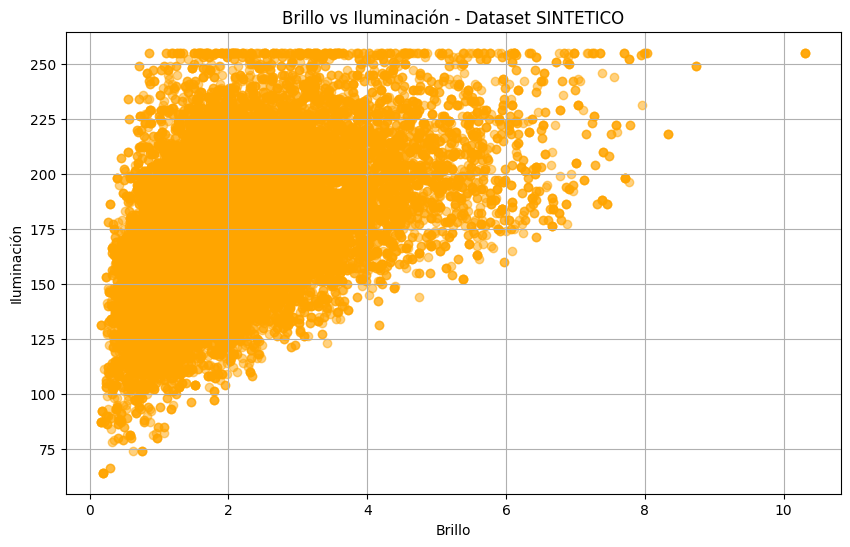

(30000, 4103)


In [40]:
# Graficar el dataset de duplicados
pyplot.figure(figsize=(10, 6))
pyplot.scatter(data_ampliado['Brillo'], data_ampliado['Iluminacion'], alpha=0.5, color='orange')
pyplot.title('Brillo vs Iluminación - Dataset SINTETICO')
pyplot.xlabel('Brillo')
pyplot.ylabel('Iluminación')
pyplot.grid()
pyplot.show()
print(data_ampliado.shape)

### 1.2 Visualización de los datos


La función muestra imágenes en una cuadrícula. Es útil para trabajar con conjuntos de datos donde las filas de X representan imágenes (por ejemplo, píxeles de una imagen en 2D), como en el caso de dígitos escritos a mano o caracteres. Cada fila de X se trata como una imagen, y esta función organiza y visualiza esas imágenes en una cuadrícula.

In [41]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Muestra datos 2D almacenados en X en una cuadrícula apropiada.
    """
    # Calcula filas, columnas (dimensiones del conjunto de datos)
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensiones.')

    #Determinar las dimensiones de cada imagen:
    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Calcula el número de elementos a mostrar (dimensiones de la cuadrícula)
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    #Crear la figura y ajustar el espaciado
    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    #Mostrar las imágenes
    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')


##Visualizacion del dataset original

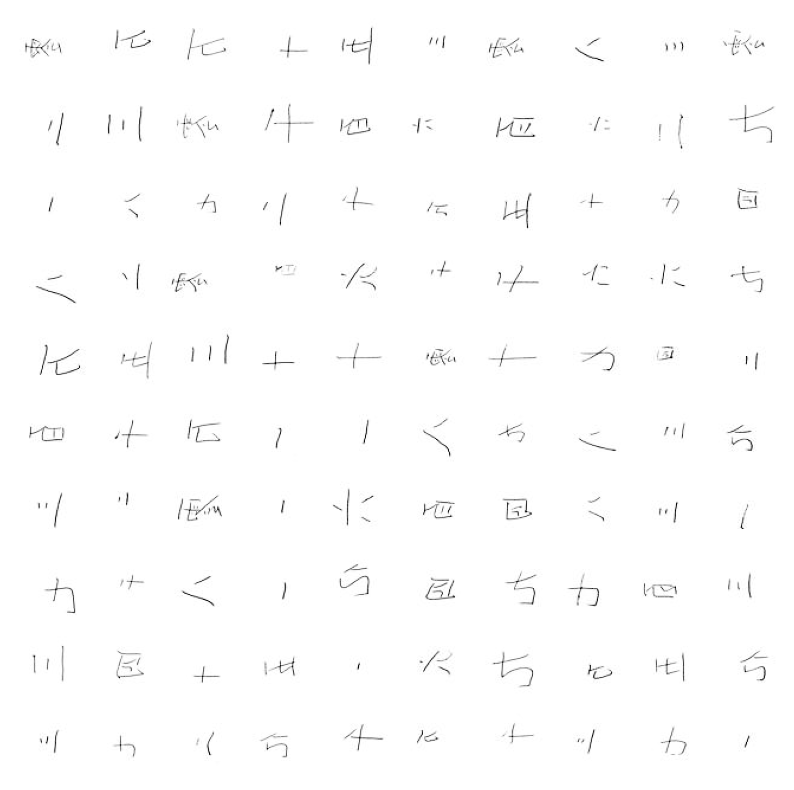

In [42]:
# Visualización del dataset original
X_original = data.iloc[:, :4096].values  # Seleccionar las primeras 4096 columnas
m_original = X_original.shape[0]  # Número de filas

# Selecciona aleatoriamente 100 puntos de datos para mostrar
rand_indices_original = np.random.choice(m_original, 100, replace=False)
sel_original = X_original[rand_indices_original, :]

displayData(sel_original)

##Visualizacion del dataset original SINTETICO

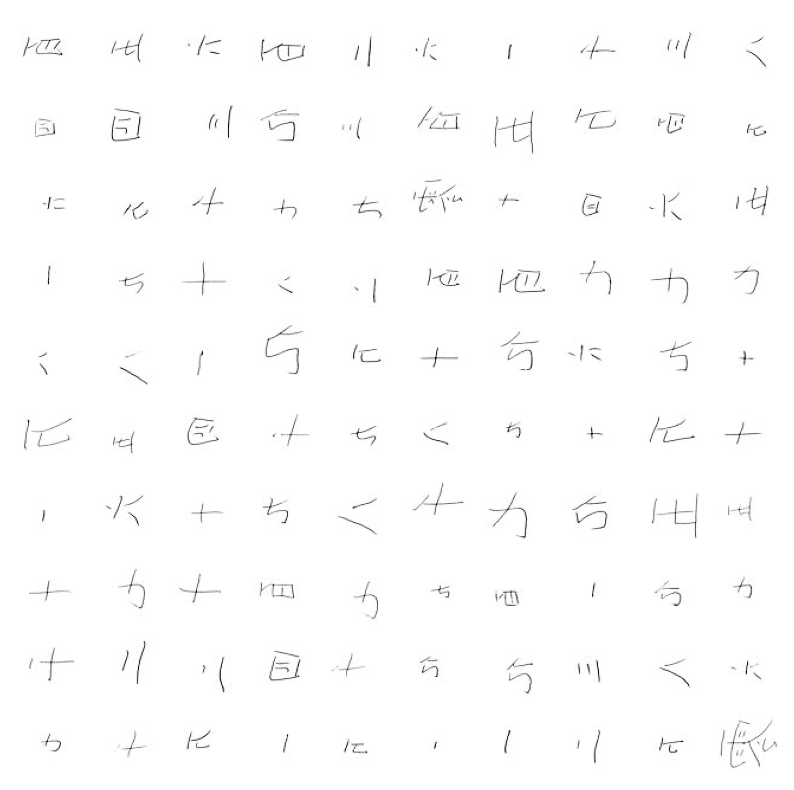

In [43]:
# Visualización del dataset sintético
X_sintetico = data_ampliado.iloc[:, :4096].values  # Seleccionar las primeras 4096 columnas
m_sintetico = X_sintetico.shape[0]  # Número de filas

# Selecciona aleatoriamente 100 puntos de datos para mostrar
rand_indices_sintetico = np.random.choice(m_sintetico, 100, replace=False)
sel_sintetico = X_sintetico[rand_indices_sintetico, :]

displayData(sel_sintetico)

#4.      Dividir los datos del dataset sintético en datos de entrenamiento y prueba

In [44]:
# Mover la columna 'label' al final
col = data_ampliado.pop('label')  # Elimina la columna 'label' y la guarda
data_ampliado['label'] = col      # Agrega la columna 'label' al final
# Imprimir las últimas 8 columnas del dataset
print(data_ampliado.iloc[:, -8:])
print(data_ampliado.shape)  # Muestra el número de filas y columnas

       pixel_4095  character    Brillo  Iluminacion  Simetria  Tipo_numero  \
0               0          9  3.866943          206         0            1   
1               0          9  2.322510          191         0            1   
2               0          9  4.155029          227         0            1   
3               0          9  3.394287          205         0            1   
4               0          9  3.656006          213         0            1   
...           ...        ...       ...          ...       ...          ...   
29995           0          7  2.294189          199         0            1   
29996           0        100  1.373291          194         1            0   
29997           0          2  1.603516          180         1            1   
29998           0       1000  3.308350          219         0            0   
29999           0          7  1.773438          233         0            1   

       pronunciacion  label  
0                  3      9  
1  

In [93]:
# Convertir el DataFrame a numpy array
data_ampliado_np = data_ampliado.to_numpy()

# Mezclar aleatoriamente las filas del dataset
np.random.seed(42)  # Para hacer reproducible la mezcla
np.random.shuffle(data_ampliado_np)

# Definir el porcentaje para el conjunto de prueba (20%)
test_size = int(0.2 * data_ampliado_np.shape[0])

# Dividir el dataset en entrenamiento y prueba
train_data = data_ampliado_np[test_size:]  # 80% entrenamiento
test_data = data_ampliado_np[:test_size]   # 20% prueba

# Separar características (X) y etiquetas (y) para el conjunto de entrenamiento
X_train = train_data[:, :-1]  # Todas las columnas menos la última ('label')
y_train = train_data[:, -1]   # La última columna es la etiqueta (y)

# Separar características (X) y etiquetas (y) para el conjunto de prueba
X_test = test_data[:, :-1]    # Todas las columnas menos la última ('label')
y_test = test_data[:, -1]     # La última columna es la etiqueta (y)

# Asumiendo que ya tienes y_train definido
m = y_train.size
# Imprimir el número de ejemplos de entrenamiento
print("Número de ejemplos de entrenamiento: m ", m)

# Imprimir tamaños de los conjuntos
print(f'Tamaño del conjunto de entrenamiento: {X_train.shape[0]}')
print(f'Tamaño del conjunto de prueba: {X_test.shape[0]}')


Número de ejemplos de entrenamiento: m  24000
Tamaño del conjunto de entrenamiento: 24000
Tamaño del conjunto de prueba: 6000


In [64]:
print(f'Conjunto de entrenamiento: {X_train}')
print(f'Conjunto de prueba: {X_test}')

Conjunto de entrenamiento: [[0. 0. 0. ... 0. 0. 4.]
 [0. 0. 0. ... 0. 1. 3.]
 [0. 0. 0. ... 0. 0. 4.]
 ...
 [0. 0. 0. ... 0. 1. 3.]
 [0. 0. 0. ... 0. 1. 3.]
 [0. 0. 0. ... 0. 1. 2.]]
Conjunto de prueba: [[0. 0. 0. ... 1. 0. 3.]
 [0. 0. 0. ... 0. 1. 4.]
 [0. 0. 0. ... 1. 0. 3.]
 ...
 [0. 0. 0. ... 1. 1. 2.]
 [0. 0. 0. ... 0. 0. 4.]
 [0. 0. 0. ... 0. 0. 4.]]


# -------------- Fin del Primer Parcial ------------------------

## Clasificación multiclase

#5.      Entrenar un modelo de regresión logística por separado, considerando el numero de clases que se vinculan al dataset elegido.

Normalización de caracteristicas

In [92]:
# Normalización de los datos de entrenamiento
'''def featureNormalize(X):
    mu = np.mean(X, axis=0)  # Media
    sigma = np.std(X, axis=0)  # Desviación estándar

    # Evitar divisiones por cero: si sigma es 0, reemplazar por 1 (no se normaliza esa columna)
    sigma[sigma == 0] = 1

    X_norm = (X - mu) / sigma  # Normalización
    return X_norm, mu, sigma

# Verificar si hay valores NaN o infinitos antes de normalizar
def check_for_nan_inf(X):
    if np.isnan(X).any():
        print("Advertencia: El conjunto de datos contiene valores NaN.")
    if np.isinf(X).any():
        print("Advertencia: El conjunto de datos contiene valores infinitos.")

# Verificar si X_train o X_test contienen NaN o infinitos
check_for_nan_inf(X_train)
check_for_nan_inf(X_test)

# Normalizar el conjunto de entrenamiento
X_train_norm, mu, sigma = featureNormalize(X_train)

# Normalizar el conjunto de prueba utilizando los mismos parámetros de entrenamiento
X_test_norm = (X_test - mu) / sigma  # Usar mu y sigma calculados de X_train

# Ahora puedes usar X_train_norm y X_test_norm para entrenar y evaluar tu modelo


##Definición de la función sigmoidea
La función toma un valor real
z y lo transforma a un rango entre 0 y 1. Esto es útil en problemas de clasificación, donde se desea que la salida esté en un rango que represente probabilidades.

Interpretación como probabilidad: En el contexto de la regresión logística, la salida de la función sigmoide se interpreta como la probabilidad de que la clase sea 1.
Tiene una forma de "S", lo que significa que las salidas cambian suavemente. Esto ayuda a evitar cambios bruscos en la salida del modelo y hace que la función sea continua y diferenciable.

In [84]:
def sigmoid(z):
    """
    Calcula la función sigmoide de z.

    Parametros
    ----------
    z : array_like
        Un número o un array de números.

    Devuelve
    -------
    array_like
        La salida de la función sigmoide aplicada a z.
    """
# Limitar z para evitar overflow
    z = np.clip(z, -500, 500)
#Establece límites en el valor de z para evitar el overflow (desbordamiento)

    return 1 / (1 + np.exp(-z))

##Función de costo regularizada
Se realiza dos tareas principales en el contexto de la regresión logística: calcular el costo (o función de pérdida) y el gradiente de los parámetros del modelo

In [99]:
def lrCostFunction(theta, X, y, lambda_):
    m = y.size  # Número de ejemplos

    # Calcula la hipótesis
    h = sigmoid(X.dot(theta))

    # Clipping para evitar log(0)
    h = np.clip(h, 1e-10, 1 - 1e-10)

    # Regularización: no regularizar el primer valor de theta
    temp = theta.copy()
    temp[0] = 0

    # Costo regularizado
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

    # Gradiente regularizado
    grad = (1 / m) * X.T.dot(h - y)
    grad += (lambda_ / m) * temp

    return J, grad


In [105]:
# Supongamos que ya tienes los valores de theta, X, y, y lambda_
theta = np.zeros(X.shape[1])  # Inicializa theta (puedes usar valores específicos)
lambda_ = 1  # Parámetro de regularización

# Calcular el costo y los gradientes
J, grad = lrCostFunction(theta, X, y, lambda_)

# Imprimir el costo y los gradientes
print('Costo         : {:.6f}'.format(J))
print('Gradientes:')
print(' [{:.6f}]'.format(*grad))  # Esto imprime cada componente de gradiente en la misma línea


Costo         : 0.693147
Gradientes:
 [0.427544]


 Entrenamiento usando One-vs-All

#La función gradientDescent
Implementa el algoritmo de descenso de gradiente para optimizar los parámetros de un modelo de regresión logística

In [100]:
def gradientDescent(X, y, theta, alpha, num_iters, lambda_):

    m = y.size  # Número de ejemplos
    J_history = []  # Historial de costos para graficar más tarde

    for _ in range(num_iters):
        # Calcular la hipótesis
        h = sigmoid(X.dot(theta))

        # Calcular el costo y el gradiente
        J, grad = lrCostFunction(theta, X, y, lambda_)

        # Actualizar theta
        theta -= alpha * grad

        # Guardar el costo en cada iteración
        J_history.append(J)

    return theta, J_history


#La función oneVsAll
Entrena varios clasificadores de regresión logística para abordar un problema de clasificación multiclase

In [101]:
def oneVsAll(X, y, num_labels, lambda_, alpha=0.01, num_iters=50):
    """
    Entrena num_labels clasificadores de regresión logística y devuelve
    cada uno de estos clasificadores en una matriz all_theta.

    Parameters
    ----------
    X : array_like
        El conjunto de datos de entrada de forma (m x n).
    y : array_like
        Las etiquetas de datos. Un vector de forma (m, ).
    num_labels : int
        Número de posibles etiquetas.
    lambda_ : float
        Parámetro de regularización.
    alpha : float
        Tasa de aprendizaje.
    num_iters : int
        Número de iteraciones para el descenso de gradiente.

    Returns
    -------
    all_theta : array_like
        Los parámetros entrenados para la regresión logística para cada clase.
        Esta es una matriz de forma (K x n+1).
    """
    m, n = X.shape
    all_theta = np.zeros((num_labels, n + 1))

    # Agregar unos a la matriz X
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    for c in range(num_labels):
        initial_theta = np.zeros(n + 1)

        # Entrenar usando descenso de gradiente
        all_theta[c], _ = gradientDescent(X, (y == c).astype(int), initial_theta, alpha, num_iters, lambda_)

    return all_theta



In [106]:
num_labels = len(np.unique(y_train))  # Número de clases únicas
lambda_ = 1  # Parámetro de regularización
alpha = 0.01  # Tasa de aprendizaje
num_iters = 50  # Número de iteraciones

all_theta = oneVsAll(X_train, y_train, num_labels, lambda_, alpha, num_iters)


Predicción

In [103]:
def predictOneVsAll(all_theta, X):
    """Devuelve un vector de predicciones para cada ejemplo en la matriz X."""
    m = X.shape[0]
    num_labels = all_theta.shape[0]
    p = np.zeros(m)
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis=1)
    return p

In [104]:
# Predicción en el conjunto de entrenamiento
pred = predictOneVsAll(all_theta, X_train)
print('Precisión del conjunto de entrenamiento: {:.2f}%'.format(np.mean(pred == y_train) * 100))

# Selecciona aleatoriamente 100 puntos de datos para mostrar
rand_indices = np.random.choice(m, 100, replace=False)
XPrueba = X_train[rand_indices, :]

# Visualización de los ejemplos de prueba
print(XPrueba.shape)
XPrueba = np.concatenate([np.ones((100, 1)), XPrueba], axis=1)
print(XPrueba.shape)
p = np.argmax(sigmoid(XPrueba.dot(all_theta.T)), axis=1)
print(p, y_train[rand_indices])



ValueError: shapes (24000,4103) and (3,15) not aligned: 4103 (dim 1) != 3 (dim 0)

====================  Fin del codigo con el Dataset PCA NN and CNN with Keras =======================